In [3]:
# For convenience, let's begin by enabling
# automatic reloading of modules when they change.
%load_ext autoreload
%autoreload 2
import qiskit_metal as metal

from qiskit_metal import designs, draw, MetalGUI, Dict, open_docs
from qiskit_metal.toolbox_metal import math_and_overrides
from qiskit_metal.qlibrary.core import QComponent
from collections import OrderedDict
from qiskit_metal.qlibrary.terminations.launchpad_wb_driven import LaunchpadWirebondDriven
from qiskit_metal.qlibrary.terminations.short_to_ground import ShortToGround
from qiskit_metal.qlibrary.terminations.launchpad_wb import LaunchpadWirebond
from qiskit_metal.qlibrary.tlines.pathfinder import RoutePathfinder
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
import numpy as np
import time

from qiskit_metal.analyses.quantization import EPRanalysis
from qiskit_metal.analyses.simulation import ScatteringImpedanceSim
from qiskit_metal.analyses.sweep_and_optimize.sweeping import Sweeping
import pyEPR as epr

design = designs.DesignPlanar()
design.overwrite_enabled = True
design.chips.main

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


{'material': 'silicon',
 'layer_start': '0',
 'layer_end': '2048',
 'size': {'center_x': '0.0mm',
  'center_y': '0.0mm',
  'center_z': '0.0mm',
  'size_x': '9mm',
  'size_y': '6mm',
  'size_z': '-750um',
  'sample_holder_top': '890um',
  'sample_holder_bottom': '1650um'}}

In [1]:
# For convenience, let's begin by enabling
# automatic reloading of modules when they change.
%load_ext autoreload
%autoreload 2

import numpy as np
from collections import OrderedDict

import warnings
warnings.filterwarnings('ignore')

import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, open_docs
import matplotlib.pyplot as plt

from qiskit_metal.toolbox_metal import math_and_overrides

from qiskit_metal.qlibrary.core import QComponent

from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal.qlibrary.tlines.pathfinder import RoutePathfinder
from qiskit_metal.qlibrary.tlines.anchored_path import RouteAnchors

from qiskit_metal.qlibrary.qubits.fluxoniumEPR import FluxoniumPocket
from qiskit_metal.qlibrary.qubits.fluxoniumLOM import FluxoniumPocket

from qiskit_metal.qlibrary.terminations.launchpad_wb import LaunchpadWirebond

from qiskit_metal.qlibrary.terminations.open_to_ground_v2 import OpenToGround

#from qiskit_metal.analyses.quantization.lumped_oscillator_model_FX import LOManalysis_FX
from qiskit_metal.analyses.quantization import LOManalysis

from qiskit_metal.qlibrary.terminations.ebeam_marker import Markers
from qiskit_metal.qlibrary.terminations.ebeam_frame import Frame


In [4]:

designs = designs.DesignPlanar()
design._chips['main']['size']['size_x'] = '9mm'
design._chips['main']['size']['size_y'] = '9mm'
gui = MetalGUI(design)

In [5]:
design.variables['cpw_width'] = '15 um'
design.variables['cpw_gap'] = '8.733 um'

In [6]:
RoutePathfinder.get_template_options(design)

{'chip': 'main',
 'layer': '1',
 'pin_inputs': {'start_pin': {'component': '', 'pin': ''},
  'end_pin': {'component': '', 'pin': ''}},
 'fillet': '0',
 'lead': {'start_straight': '0mm',
  'end_straight': '0mm',
  'start_jogged_extension': '',
  'end_jogged_extension': ''},
 'total_length': '7mm',
 'trace_width': 'cpw_width',
 'anchors': {},
 'advanced': {'avoid_collision': 'true'},
 'step_size': '0.25mm',
 'hfss_wire_bonds': False,
 'q3d_wire_bonds': False}

In [7]:
#Setup the launchpad1 location and orientation

## Read In launch pad
launch_options = dict(chip='main', pos_x='-4.0mm', pos_y='-3.99mm', orientation='0',
        lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='112um',
                    )
lp = LaunchpadWirebond(design, 'LPReadIn', options = launch_options)


# Read Out launch pad
launch_options = dict(chip='main', pos_x='4.0mm', pos_y='3.99mm', orientation='180',
                      lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='112um',
                    )
lp = LaunchpadWirebond(design, 'LPReadOut', options = launch_options)



Transmission_Line = {'pin_inputs':
           {'start_pin': {'component': 'LPReadIn', 'pin': 'tie'},
             'end_pin': {'component': 'LPReadOut', 'pin': 'tie'}},
            'lead': {'start_straight': '3970um', 'end_straight': '3970um',
                    # 'start_jogged_extension': jogs_in,
                    # 'anchors': anchors1,
                    }, 
                    'total_length': '8mm', 'fillet': "90um"
            }

TransLine = RoutePathfinder(design, 'TL', Transmission_Line)


gui.rebuild()

In [23]:
x = '-4.1mm' 
y = '-3.5mm'
launch_options = dict(chip='main', pos_x=x, pos_y=y, orientation='360', lead_length='30um', pad_width = '150um', pad_height = '150um', pad_gap = '80um')
LP1 = LaunchpadWirebondDriven(design, 'LP1', options = launch_options)


x = '4.1mm' 
y = '3.5mm'
launch_options = dict(chip='main', pos_x=x, pos_y=y, orientation='180', lead_length='30um', pad_width = '150um', pad_height = '150um', pad_gap = '80um')
LP2 = LaunchpadWirebondDriven(design, 'LP2', options = launch_options)


straight = '8mm'
length = '25mm'
spacing = '3mm'
feedline = RoutePathfinder(design, 'feedline',  Dict(
        trace_width = '15um',
        trace_gap ='8.733um',
        spacing = spacing,
        total_length=length,
        hfss_wire_bonds = False,
        fillet='99 um',
        meander = dict(spacing= spacing, asymmetry ='0um'),
        lead = dict(start_straight=straight, end_straight = straight),
        pin_inputs=Dict(
            start_pin=Dict(component='LP1', pin='tie'),
            end_pin=Dict(component='LP2', pin='tie')), ))
gui.rebuild()

10:23PM 38s ERROR [rebuild]: ERROR in building component name=feedline, error='NoneType' object has no attribute 'coords'


AttributeError: 'NoneType' object has no attribute 'coords'

In [8]:
eps_r = 11.7
W = 15
S = 8.733
H = 500
eps_eff=6.349
v = 3e8/np.sqrt(eps_eff)
l = 0.00355
for i in range(12):
    f_2 = v/(l*4)
    print("Resonator", i + 1, "length:", np.round(l*1e3, 2), "mm")
    print("Frequency:", np.round(f_2/1e9,3))
    l  = l + 0.0001

Resonator 1 length: 3.55 mm
Frequency: 8.385
Resonator 2 length: 3.65 mm
Frequency: 8.155
Resonator 3 length: 3.75 mm
Frequency: 7.937
Resonator 4 length: 3.85 mm
Frequency: 7.731
Resonator 5 length: 3.95 mm
Frequency: 7.535
Resonator 6 length: 4.05 mm
Frequency: 7.349
Resonator 7 length: 4.15 mm
Frequency: 7.172
Resonator 8 length: 4.25 mm
Frequency: 7.004
Resonator 9 length: 4.35 mm
Frequency: 6.843
Resonator 10 length: 4.45 mm
Frequency: 6.689
Resonator 11 length: 4.55 mm
Frequency: 6.542
Resonator 12 length: 4.65 mm
Frequency: 6.401


In [9]:
e = '0um'
lcoup = 0.125 # double this value = coupling length 
x1 = '0.5mm' 
#x2 = '{}mm'.format(float(x1[:-2]) + (lcoup +2.2/7))
x2='0.8mm'
otg1 = OpenToGround(design, 'otg1s', options=dict(chip='main', pos_x=x1,  pos_y='3.438mm', orientation='180'))
stg1 = ShortToGround(design, 'stg1e', options=dict(chip='main', pos_x=x2,  pos_y='2.4mm', orientation='270'))

resonator1 = RouteMeander(design, 'resonator1',  Dict(
        trace_width ='12um',
        trace_gap ='5um',
        total_length='3.95mm',
        hfss_wire_bonds = True,
        fillet='99 um',
        lead = dict(start_straight='250um'),
        pin_inputs=Dict(
            start_pin=Dict(component='otg1s', pin='open'),
            end_pin=Dict(component='stg1e', pin='short')), ))


gui.rebuild()

In [ ]:
e = '0um'
lcoup = 0.125 # double this value = coupling length 


x1 = '0.8mm' 
x2 = '{}mm'.format(float(x1[:-2]) + (lcoup+2.2/7))
stg21 = ShortToGround(design, 'stg21s', options=dict(chip='main', pos_x=x1,  pos_y='3.438mm', orientation='180'))
otg21 = OpenToGround(design, 'otg21e', options=dict(chip='main', pos_x=x2 ,  pos_y='2.4mm', orientation='270'))

resonator2 = RouteMeander(design, 'resonator2',  Dict(
        trace_width ='12um',
        trace_gap ='5um',
        total_length='3.95mm',
        hfss_wire_bonds = True,
        fillet='99 um',
        lead = dict(start_straight='{}mm'.format(lcoup+2.2/7),end_straight=e),
        pin_inputs=Dict(
            start_pin=Dict(component='stg21s', pin='short'),
            end_pin=Dict(component='otg21e', pin='open')), ))


x1 = '-1mm' 
x2 = '{}mm'.format(float(x1[:-2]) + (lcoup+2.2/7))
stg31 = OpenToGround(design, 'stg31s', options=dict(chip='main', pos_x=x1,  pos_y='3.438mm', orientation='180'))
otg31 = OpenToGround(design, 'otg31e', options=dict(chip='main', pos_x=x2 ,  pos_y='2.4mm', orientation='270'))

resonator3 = RouteMeander(design, 'resonator3',  Dict(
        trace_width ='12um',
        trace_gap ='5um',
        total_length='3.95mm',
        hfss_wire_bonds = True,
        fillet='99 um',
        lead = dict(start_straight='{}mm'.format(lcoup+2.2/7),end_straight=e),
        pin_inputs=Dict(
            start_pin=Dict(component='stg31s', pin='open'),
            end_pin=Dict(component='otg31e', pin='open')), ))



x1 = '-2.8mm' 
x2 = '{}mm'.format(float(x1[:-2]) + (lcoup+2.2/7))
                   
stg2 = OpenToGround(design, 'stg2s', options=dict(chip='main', pos_x=x1,  pos_y='3.438mm', orientation='180'))
otg2 = OpenToGround(design, 'otg2e', options=dict(chip='main', pos_x=x2,  pos_y='2.4mm', orientation='270'))

resonator4 = RouteMeander(design, 'resonator4',  Dict(
        trace_width ='12um',
        trace_gap ='5um',
        total_length='3.95mm',
        hfss_wire_bonds = True,
        fillet='99 um',
        lead = dict(start_straight='{}mm'.format(lcoup+2.2/7),end_straight=e),
        pin_inputs=Dict(
            start_pin=Dict(component='stg2s', pin='open'),
            end_pin=Dict(component='otg2e', pin='open')), ))


x1 = '3.5mm' 
x2 = '{}mm'.format(float(x1[:-2]) - (lcoup+2.2/7))
stg3 = OpenToGround(design, 'stg3s', options=dict(chip='main', pos_x=x1,  pos_y='0.062mm', orientation='0'))
otg3 = OpenToGround(design, 'otg3e', options=dict(chip='main', pos_x=x2,  pos_y='1.1mm', orientation='90'))

resonator5 = RouteMeander(design, 'resonator5',  Dict(
        trace_width ='12um',
        trace_gap ='5um',
        total_length='3.85mm',
        hfss_wire_bonds = True,
        fillet='99 um',
        lead = dict(start_straight='{}mm'.format(lcoup+2.2/7),end_straight=e),
        pin_inputs=Dict(
            start_pin=Dict(component='stg3s', pin='open'),
            end_pin=Dict(component='otg3e', pin='open')), ))

x1 = '1.7mm' 
x2 = '{}mm'.format(float(x1[:-2]) - (lcoup+2.2/7))
stg4 = OpenToGround(design, 'stg4s', options=dict(chip='main', pos_x=x1,  pos_y='0.062mm', orientation='0'))
otg4 = OpenToGround(design, 'otg4e', options=dict(chip='main', pos_x=x2,  pos_y='1.1mm', orientation='90'))

resonator6 = RouteMeander(design, 'resonator6',  Dict(
        trace_width ='12um',
        trace_gap ='5um',
        total_length='3.85mm',
        hfss_wire_bonds = True,
        fillet='99 um',
        lead = dict(start_straight='{}mm'.format(lcoup+2.2/7),end_straight=e),
        pin_inputs=Dict(
            start_pin=Dict(component='stg4s', pin='open'),
            end_pin=Dict(component='otg4e', pin='open')), ))


x1 = '-0.1mm' 
x2 = '{}mm'.format(float(x1[:-2]) - (lcoup+2.2/7))
stg5 = OpenToGround(design, 'stg5s', options=dict(chip='main', pos_x=x1,  pos_y='0.062mm', orientation='0'))
otg5 = OpenToGround(design, 'otg5e', options=dict(chip='main', pos_x=x2,  pos_y='1.1mm', orientation='90'))

resonator7 = RouteMeander(design, 'resonator7',  Dict(
        trace_width ='12um',
        trace_gap ='5um',
        total_length='3.85mm',
        hfss_wire_bonds = True,
        fillet='99 um',
        lead = dict(start_straight='{}mm'.format(lcoup+2.2/7),end_straight=e),
        pin_inputs=Dict(
            start_pin=Dict(component='stg5s', pin='open'),
            end_pin=Dict(component='otg5e', pin='open')), ))

x1 = '-1.9mm' 
x2 = '{}mm'.format(float(x1[:-2]) - (lcoup+2.2/7))
stg6 = OpenToGround(design, 'stg6s', options=dict(chip='main', pos_x=x1,  pos_y='0.062mm', orientation='0'))
otg6 = OpenToGround(design, 'otg6e', options=dict(chip='main', pos_x=x2,  pos_y='1.1mm', orientation='90'))

resonator8 = RouteMeander(design, 'resonator8',  Dict(
        trace_width ='12um',
        trace_gap ='5um',
        total_length='3.85mm',
        hfss_wire_bonds = True,
        fillet='99 um',
        lead = dict(start_straight='{}mm'.format(lcoup+2.2/7),end_straight=e),
        pin_inputs=Dict(
            start_pin=Dict(component='stg6s', pin='open'),
            end_pin=Dict(component='otg6e', pin='open')), ))


x1 = '1.8mm' 
x2 = '{}mm'.format(float(x1[:-2]) + (lcoup+2.2/7))
stg41 = OpenToGround(design, 'stg41s', options=dict(chip='main', pos_x=x1,  pos_y='-0.062mm', orientation='180'))
otg41 = OpenToGround(design, 'otg41e', options=dict(chip='main', pos_x=x2 ,  pos_y='-1.1mm', orientation='270'))

resonator9 = RouteMeander(design, 'resonator9',  Dict(
        trace_width ='12um',
        trace_gap ='5um',
        total_length='3.75mm',
        hfss_wire_bonds = True,
        fillet='99 um',
        lead = dict(start_straight='{}mm'.format(lcoup+2.2/7),end_straight=e),
        pin_inputs=Dict(
            start_pin=Dict(component='stg41s', pin='open'),
            end_pin=Dict(component='otg41e', pin='open')), ))


x1 = '0mm' 
x2 = '{}mm'.format(float(x1[:-2]) + (lcoup+2.2/7))
stg51 = OpenToGround(design, 'stg51s', options=dict(chip='main', pos_x=x1,  pos_y='-0.062mm', orientation='180'))
otg51 = OpenToGround(design, 'otg51e', options=dict(chip='main', pos_x=x2 ,  pos_y='-1.1mm', orientation='270'))

resonator10 = RouteMeander(design, 'resonator10',  Dict(
        trace_width ='12um',
        trace_gap ='5um',
        total_length='3.75mm',
        hfss_wire_bonds = True,
        fillet='99 um',
        lead = dict(start_straight='{}mm'.format(lcoup+2.2/7),end_straight=e),
        pin_inputs=Dict(
            start_pin=Dict(component='stg51s', pin='open'),
            end_pin=Dict(component='otg51e', pin='open')), ))



x1 = '-1.8mm' 
x2 = '{}mm'.format(float(x1[:-2]) + (lcoup+2.2/7))
stg7 = OpenToGround(design, 'stg7s', options=dict(chip='main', pos_x=x1,  pos_y='-0.062mm', orientation='180'))
otg7 = OpenToGround(design, 'otg7e', options=dict(chip='main', pos_x=x2,  pos_y='-1.1mm', orientation='270'))

resonator11 = RouteMeander(design, 'resonator11',  Dict(
        trace_width ='12um',
        trace_gap ='5um',
        total_length='3.75mm',
        hfss_wire_bonds = True,
        fillet='99 um',
        lead = dict(start_straight='{}mm'.format(lcoup+2.2/7),end_straight=e),
        pin_inputs=Dict(
            start_pin=Dict(component='stg7s', pin='open'),
            end_pin=Dict(component='otg7e', pin='open')), ))


x1 = '-3.5mm' 
x2 = '{}mm'.format(float(x1[:-2]) + (lcoup+2.2/7))
stg8 = OpenToGround(design, 'stg8s', options=dict(chip='main', pos_x=x1, pos_y='-0.062mm', orientation='180'))
otg8 = OpenToGround(design, 'otg8e', options=dict(chip='main', pos_x=x2, pos_y='-1.1mm', orientation='270'))

resonator12 = RouteMeander(design, 'resonator12',  Dict(
        trace_width ='12um',
        trace_gap ='5um',
        total_length='3.75mm',
        hfss_wire_bonds = True,
        fillet='99um',
        meander = dict(spacing='200um'),
        lead = dict(start_straight='{}mm'.format(lcoup+2.2/7),end_straight=e),
        pin_inputs=Dict(
            start_pin=Dict(component='stg8s', pin='open'),
            end_pin=Dict(component='otg8e', pin='open')), ))

x1 = '2.8mm' 
x2 = '{}mm'.format(float(x1[:-2]) - (lcoup+2.2/7))
stg13 = OpenToGround(design, 'stg13s', options=dict(chip='main', pos_x=x1, pos_y='-3.438mm', orientation='0'))
otg13 = OpenToGround(design, 'otg13e', options=dict(chip='main', pos_x=x2, pos_y='-2.4mm', orientation='90'))

resonator13 = RouteMeander(design, 'resonator13',  Dict(
        trace_width ='12um',
        trace_gap ='5um',
        total_length='3.65mm',
        hfss_wire_bonds = True,
        fillet='99um',
        meander = dict(spacing='200um'),
        lead = dict(start_straight='{}mm'.format(lcoup+2.2/7),end_straight=e),
        pin_inputs=Dict(
            start_pin=Dict(component='stg13s', pin='open'),
            end_pin=Dict(component='otg13e', pin='open')), ))

x1 = '1mm' 
x2 = '{}mm'.format(float(x1[:-2]) - (lcoup+2.2/7))
stg14 = OpenToGround(design, 'stg14s', options=dict(chip='main', pos_x=x1, pos_y='-3.438mm', orientation='0'))
otg14 = OpenToGround(design, 'otg14e', options=dict(chip='main', pos_x=x2, pos_y='-2.4mm', orientation='90'))

resonator14 = RouteMeander(design, 'resonator14',  Dict(
        trace_width ='12um',
        trace_gap ='5um',
        total_length='3.65mm',
        hfss_wire_bonds = True,
        fillet='99um',
        meander = dict(spacing='200um'),
        lead = dict(start_straight='{}mm'.format(lcoup+2.2/7),end_straight=e),
        pin_inputs=Dict(
            start_pin=Dict(component='stg14s', pin='open'),
            end_pin=Dict(component='otg14e', pin='open')), ))
x1 = '-0.8mm' 
x2 = '{}mm'.format(float(x1[:-2]) - (lcoup+2.2/7))
stg15 = OpenToGround(design, 'stg15s', options=dict(chip='main', pos_x=x1, pos_y='-3.438mm', orientation='0'))
otg15 = OpenToGround(design, 'otg15e', options=dict(chip='main', pos_x=x2, pos_y='-2.4mm', orientation='90'))

resonator15 = RouteMeander(design, 'resonator15',  Dict(
        trace_width ='12um',
        trace_gap ='5um',
        total_length='3.65mm',
        hfss_wire_bonds = True,
        fillet='99um',
        meander = dict(spacing='200um'),
        lead = dict(start_straight='{}mm'.format(lcoup+2.2/7),end_straight=e),
        pin_inputs=Dict(
            start_pin=Dict(component='stg15s', pin='open'),
            end_pin=Dict(component='otg15e', pin='open')), ))
x1 = '-2.6mm' 
x2 = '{}mm'.format(float(x1[:-2]) - (lcoup+2.2/7))
stg16 = OpenToGround(design, 'stg16s', options=dict(chip='main', pos_x=x1, pos_y='-3.438mm', orientation='0'))
otg16 = OpenToGround(design, 'otg16e', options=dict(chip='main', pos_x=x2, pos_y='-2.4mm', orientation='90'))

resonator16 = RouteMeander(design, 'resonator16',  Dict(
        trace_width ='12um',
        trace_gap ='5um',
        total_length='3.65mm',
        hfss_wire_bonds = True,
        fillet='99um',
        meander = dict(spacing='200um'),
        lead = dict(start_straight='{}mm'.format(lcoup+2.2/7),end_straight=e),
        pin_inputs=Dict(
            start_pin=Dict(component='stg16s', pin='open'),
            end_pin=Dict(component='otg16e', pin='open')), ))


gui.rebuild()

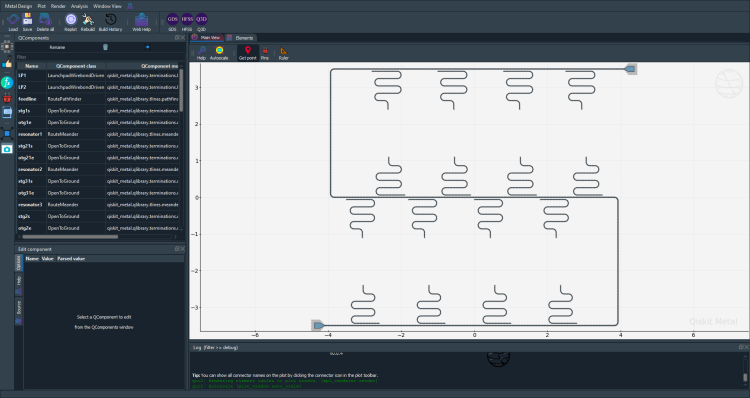

In [89]:
gui.autoscale()
gui.screenshot()

In [90]:
a_gds = design.renderers.gds
a_gds.options['no_cheese']['buffer'] = '30um'
a_gds.options

{'short_segments_to_not_fillet': 'True',
 'check_short_segments_by_scaling_fillet': '2.0',
 'gds_unit': 0.001,
 'ground_plane': 'True',
 'negative_mask': {'main': []},
 'fabricate': 'False',
 'corners': 'circular bend',
 'tolerance': '0.00001',
 'precision': '0.000000001',
 'width_LineString': '10um',
 'path_filename': '../resources/Fake_Junctions.GDS',
 'junction_pad_overlap': '5um',
 'max_points': '199',
 'cheese': {'datatype': '100',
  'shape': '0',
  'cheese_0_x': '25um',
  'cheese_0_y': '25um',
  'cheese_1_radius': '100um',
  'view_in_file': {'main': {1: True}},
  'delta_x': '100um',
  'delta_y': '100um',
  'edge_nocheese': '200um'},
 'no_cheese': {'datatype': '99',
  'buffer': '30um',
  'cap_style': '2',
  'join_style': '2',
  'view_in_file': {'main': {1: True}}},
 'bounding_box_scale_x': '1.2',
 'bounding_box_scale_y': '1.2'}

In [91]:
#res.options['path_filename'] = 'C:\Users\LocalAdmin\Documents\Shikhar\Resonator_freq_simulations_1' 
#a_gds.export_to_gds('design.gds') #buffer = 25um
a_gds.export_to_gds('res_jj_16_V2.gds') #buffer = 30um

  all_polys = list(multi_poly)

  all_polys = list(multi_poly)



1